In [1]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import pipeline
from sklearn.feature_selection import chi2, mutual_info_regression, f_regression, mutual_info_classif, f_classif, SelectFdr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
#import mglearn
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import pickle
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline


In [3]:


train_data = pd.read_table('train_data.txt', delimiter='\t')
test_data = pd.read_table('test_data.txt', delimiter='\t')

train_date = [int(str(i)[:8]) for i in train_data['time']]
test_date = [int(str(i)[:8]) for i in test_data['time']]

subset_train = [ i == 20170808 for i in train_date]
subset_test = [ i == 20170809 for i in test_date]

train_data_correct = train_data.loc[subset_train]
test_data_correct = test_data.loc[subset_test]

x_train = train_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_train = train_data_correct['label']

x_test = test_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_test = test_data_correct['label']

label_encode = LabelEncoder()
stadard_scaler = StandardScaler()
onehot_encode = OneHotEncoder()

In [4]:
data_all = pd.concat([x_train, x_test], axis=0, ignore_index = True)

In [ ]:
data_all_scale = MaxAbs

In [5]:
data_obj = data_all.select_dtypes(include=['object']).copy().iloc[:, [ 0,  1,  3,  6,  8,  9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22]]

In [6]:
data_num = data_all.select_dtypes(include=['int64']).copy()


## Minmax scaler

In [7]:
minmax_scaler = MinMaxScaler()
#data_num_scaled = minmax_scaler.fit_transform(np.array(data_num).astype(float))

In [8]:
#data_num_pd = pd.DataFrame(data_num_scaled, columns=data_num.columns)
final = pd.concat([data_num, data_obj], axis = 1, ignore_index=True)
final.shape

(8946606, 23)

In [9]:
from sklearn.preprocessing import MaxAbsScaler
final_dummy = pd.get_dummies(final)
max_scale= MaxAbsScaler()
final_scale = max_scale.fit_transform(final_dummy)
x_train_final = final_dummy.iloc[:(4500638),:]
x_test_final = final_dummy.iloc[(4500638):,:]

In [10]:
x_train_final.shape

(4500638, 175)

In [11]:
x_train_final.shape[0] == x_train.shape[0]

True

#### Save the data

In [13]:
pickle_out = open("x_train_final.pickle","wb")
pickle.dump(x_train_final, pickle_out)
pickle_out.close()


In [14]:
pickle_out = open("x_test_final.pickle","wb")
pickle.dump(x_test_final, pickle_out)
pickle_out.close()



In [15]:
pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()



In [16]:
pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()



#### Load data

In [5]:
x_train_final = pickle.load( open( "x_train_final.pickle", "rb" ) )
x_test_final = pickle.load(open("x_test_final.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

In [6]:
y_test_obs = y_test

### A. Random undersampler

### Minmax + undersampling + selectK + logistic regression

In [12]:
US = RandomUnderSampler(return_indices=True)
x_train_final_US, y_train_US, idx_US = US.fit_sample(x_train_final, y_train)

In [13]:
pd.Series(y_train_US).value_counts()

1    14839
0    14839
dtype: int64

In [14]:
logi_reg = LogisticRegression( solver='lbfgs')

In [15]:
model1 = Pipeline([ 
    ('selectK',  SelectKBest(k=30)),  
    ('logistic', logi_reg)
])



In [16]:
model1.fit(x_train_final_US,y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  36  38  41  44  70  77  80  95 135 141 142 143 146 148
 150 151 157 160 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=30, score_func=<function f_classif at 0x117250bf8>)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
y_test_pred_1 = model1.predict(x_test_final)


In [18]:
pd.Series(y_test_pred_1).value_counts()
y_test_obs = y_test

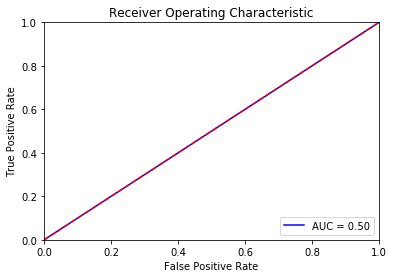

In [19]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_1)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Minmax  + undersampling + selectK (bestK gridsearchCV) + logistic reg 

In [13]:
model2 = Pipeline([ 
    ('selectK',  SelectKBest(k=20)),  
    ('logireg', logi_reg)
])



In [14]:
N_FEATURES_OPTIONS = [5, 20, 40]
C_OPTIONS = [1e-1, 1, 10, 100]
param_grid = [
    {
        'selectK': [SelectKBest(mutual_info_classif)],
        'selectK__k': N_FEATURES_OPTIONS,
        'logireg__C': C_OPTIONS
    },
]
reducer_labels = [ 'KBest(mutual_inf)']

In [15]:
grid = GridSearchCV(model2, cv=2, n_jobs=1, param_grid=param_grid)
grid.fit(x_train_final_US, y_train_US)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=20, score_func=<function f_classif at 0x116bffbf8>)), ('logireg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'selectK': [SelectKBest(k=40, score_func=<function mutual_info_classif at 0x116dcf7b8>)], 'selectK__k': [5, 20, 40], 'logireg__C': [0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

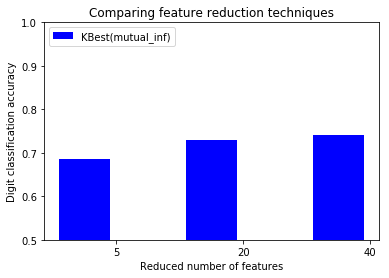

In [16]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0.5, 1))
plt.legend(loc='upper left')
plt.show()

In [17]:
grid.best_params_

{'logireg__C': 1,
 'selectK': SelectKBest(k=40, score_func=<function mutual_info_classif at 0x116dcf7b8>),
 'selectK__k': 40}

In [18]:
model3 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('logireg', LogisticRegression(C=1))
])




In [19]:
model3.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  27  36  38  70  77  78  80  95 141 142 143 146 148 150 151 157
 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x116bffbf8>)), ('logireg', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
y_test_pred_3 = model3.predict(x_test_final)

In [21]:
pd.Series(y_test_pred_3).value_counts()

0    3414335
1    1031633
dtype: int64

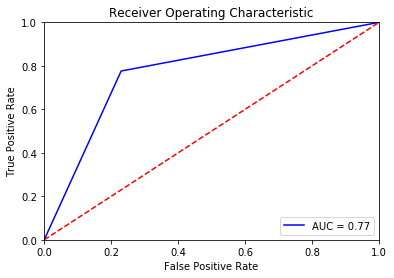

In [22]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_3)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




### Minmax  + undersampling + selectK + decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
model4 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('tree', DecisionTreeClassifier())
])



In [22]:
model4.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  36  38  41  44  70  77  80  95 135 141 142 143 146 148
 150 151 157 160 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x117250bf8>)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [23]:
y_test_pred_4 = model4.predict(x_test_final)

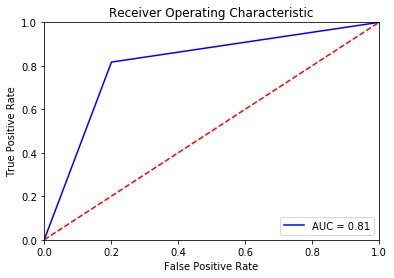

In [24]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_4)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [25]:
x_train_final_US.shape

(29678, 175)

### Minmax  + undersampling + selectK + randomforest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
model5 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('rf', RandomForestClassifier())
])



In [28]:
model5.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  36  38  41  44  70  77  80  95 135 141 142 143 146 148
 150 151 157 160 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x117250bf8>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=No...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [29]:
y_test_pred_5 = model5.predict(x_test_final)

In [30]:
model5.get_params()

{'memory': None,
 'rf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 10,
 'rf__n_jobs': 1,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False,
 'selectK': SelectKBest(k=40, score_func=<function f_classif at 0x117250bf8>),
 'selec

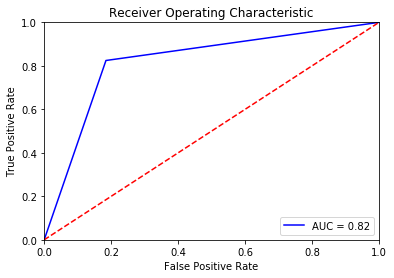

In [31]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_5)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Minmax  + undersampling + selectK + adaBoost


In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [29]:
model6 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('ada', AdaBoostClassifier())
])



In [30]:
model6.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  30  36  38  41  77  78  80  95 141 142 143 148 150 151 157 161] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x11320e510>)), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])

In [33]:
y_test_pred_6 = model6.predict(x_test_final)

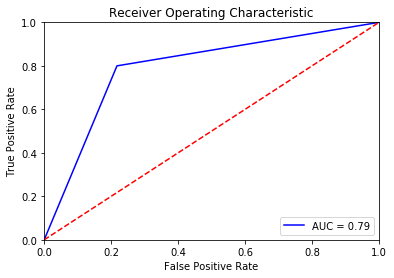

In [34]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_6)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Minmax  + undersampling + selectK + NaiveBayes 

In [9]:
from sklearn.naive_bayes import GaussianNB

In [10]:
model7 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('gaussianNB', GaussianNB())
])



In [11]:
model7.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  30  36  38  76  77  78  80  95 141 142 143 146 148 150 151 157
 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x110599bf8>)), ('gaussianNB', GaussianNB(priors=None))])

In [12]:
y_test_pred_7 = model7.predict(x_test_final)

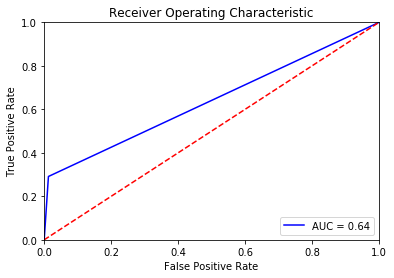

In [14]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_7)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Minmax  + undersampling + selectK + QDA 


In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [17]:
model8 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('QDA', QuadraticDiscriminantAnalysis())
])



In [18]:
model8.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  30  36  38  76  77  78  80  95 141 142 143 146 148 150 151 157
 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x110599bf8>)), ('QDA', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001))])

In [19]:
y_test_pred_8 = model8.predict(x_test_final)

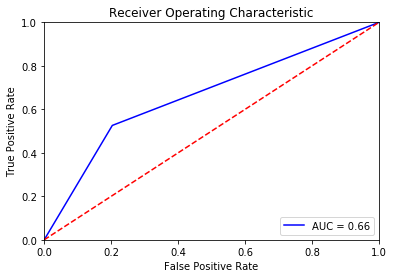

In [20]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_8)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random forest grid search

In [25]:
param_grid = {"rf__max_depth": [3, 5, None],
              "rf__max_features": ['auto', 20, 40],
              "rf__criterion": ["gini", "entropy"]}

# run grid search

from sklearn.ensemble import RandomForestClassifier

model5 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('rf', RandomForestClassifier())
])


In [26]:
grid = GridSearchCV(model5, cv=2, n_jobs=1, param_grid=param_grid)
grid.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  23  24  27  38  41  53  70  74  76  77  78  80  95 101 135 136 141
 142 143 146 148 150 151 157 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  26  27  30  36  38  41  44  70  74  75  76  77  78  80  95 135
 141 142 143 148 150 151 157 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selecti

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x116249bf8>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=No...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__max_depth': [3, 5, None], 'rf__max_features': ['auto', 20, 40], 'rf__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(grid.cv_results_)


Model with rank: 1
Mean validation score: 0.810 (std: 0.002)
Parameters: {'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__max_features': 20}

Model with rank: 2
Mean validation score: 0.809 (std: 0.001)
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 20}

Model with rank: 3
Mean validation score: 0.808 (std: 0.003)
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 40}



#### Now use selected features

In [10]:
from sklearn.ensemble import RandomForestClassifier


In [11]:
model6 = Pipeline([ 
    ('selectK',  SelectKBest(k=40)),  
    ('rf', RandomForestClassifier(criterion='entropy', max_depth=None, max_features=20))
])



In [12]:
model6.fit(x_train_final_US, y_train_US)

/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  24  30  36  38  41  70  77  80  95 141 142 143 146 148 150 151 157
 161 164] are constant.
  UserWarning)
/Users/LilSummer/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('selectK', SelectKBest(k=40, score_func=<function f_classif at 0x11af2b7b8>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=Non...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [13]:
y_test_pred_6 = model6.predict(x_test_final)

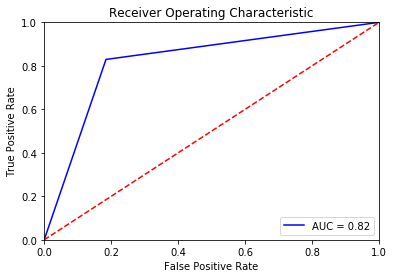

In [15]:
fpr, tpr, threshold = roc_curve(y_test_obs, y_test_pred_6)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
